In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
%matplotlib inline
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import TensorBoard
from keras.models import load_model



# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# load dataset
dataset = read_csv('ALV100_day.csv', parse_dates=['Date'] )
dataset =  dataset[:96*31]
dataset = dataset.set_index('Date')
dataset = dataset[['Flow','TimePeriod','AverageJT','AverageSpeed','DataQuality','LinkLength','day']]
values = dataset.values#converting to  numpy
values

array([[ 31.        ,   0.        , 138.25      , ...,   1.        ,
          4.51171875,   6.        ],
       [ 32.5       ,   1.        , 138.25      , ...,   1.        ,
          4.51171875,   6.        ],
       [ 26.5       ,   2.        , 138.25      , ...,   1.        ,
          4.51171875,   6.        ],
       ...,
       [ 48.5       ,  93.        , 154.25      , ...,   1.        ,
          4.51171875,   1.        ],
       [ 40.5       ,  94.        , 154.25      , ...,   1.        ,
          4.51171875,   1.        ],
       [ 32.5       ,  95.        , 154.625     , ...,   3.        ,
          4.51171875,   1.        ]])

In [3]:
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [4]:
# specify the number of lag hours
n_hours = 96 #Days is used to Decide input steps it should be decided on input we have 96 input for a day
n_features = 7 #
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)
reframed

,var1(t-96),var2(t-96),var3(t-96),var4(t-96),var5(t-96),var6(t-96),var7(t-96),var1(t-95),var2(t-95),var3(t-95),...,var5(t-1),var6(t-1),var7(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t)
96,0.064880,0.000000,0.027142,0.747951,0.0,0.0,1.0,0.069111,0.010526,0.027142,...,0.5,0.0,1.000000,0.030324,0.000000,0.047219,0.625718,0.5,0.0,0.000000
97,0.069111,0.010526,0.027142,0.747951,0.0,0.0,1.0,0.052186,0.021053,0.027142,...,0.5,0.0,0.000000,0.031030,0.010526,0.025230,0.761780,0.5,0.0,0.000000
98,0.052186,0.021053,0.027142,0.747951,0.0,0.0,1.0,0.043724,0.031579,0.027142,...,0.5,0.0,0.000000,0.023272,0.021053,0.031816,0.715831,0.5,0.0,0.000000
99,0.043724,0.031579,0.027142,0.747951,0.0,0.0,1.0,0.028209,0.042105,0.027142,...,0.5,0.0,0.000000,0.012694,0.031579,0.021405,0.790777,0.5,0.0,0.000000
100,0.028209,0.042105,0.027142,0.747951,0.0,0.0,1.0,0.025388,0.052632,0.037552,...,0.5,0.0,0.000000,0.009873,0.042105,0.033303,0.706463,0.5,0.0,0.000000
101,0.025388,0.052632,0.037552,0.680143,0.5,0.0,1.0,0.022567,0.063158,0.045201,...,0.5,0.0,0.000000,0.009168,0.052632,0.025655,0.758657,0.5,0.0,0.000000
102,0.022567,0.063158,0.045201,0.635978,0.5,0.0,1.0,0.015515,0.073684,0.044033,...,0.5,0.0,0.000000,0.004937,0.063158,0.026611,0.751966,0.5,0.0,0.000000
103,0.015515,0.073684,0.044033,0.642670,0.5,0.0,1.0,0.008463,0.084211,0.049238,...,0.5,0.0,0.000000,0.005642,0.073684,0.050300,0.610104,0.5,0.0,0.000000
104,0.008463,0.084211,0.049238,0.615458,0.5,0.0,1.0,0.014104,0.094737,0.048388,...,0.5,0.0,0.000000,0.004937,0.084211,0.059648,0.566386,0.5,0.0,0.000000
105,0.014104,0.094737,0.048388,0.619473,0.5,0.0,1.0,0.009873,0.105263,0.056461,...,0.5,0.0,0.000000,0.002821,0.094737,0.045414,0.635086,0.5,0.0,0.000000


In [5]:
# split into train and test sets
values = reframed.values
n_train_hours = 96*31
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#split into input and outputs
n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


((2880, 672), 2880, (2880,))
((2880, 96, 7), (2880,), (0, 96, 7), (0,))


In [6]:
365*24

8760

## Instead  of training we are using previously trained weights

In [7]:
model = Sequential()
model = load_model("model_8epochs_loss_mae.h5")

In [8]:
train_yhat = model.predict(train_X)
print("predication done")

train_X = train_X.reshape((train_X.shape[0], n_hours*n_features))
print("reshaped")
# invert scaling for forecast
train_inv_yhat = concatenate((train_yhat, train_X[:,  -(n_features-1):]), axis=1)
print("concated")

train_inv_yhat_testpoint = concatenate((train_yhat, train_X[:,  -(n_features-1):]), axis=1)
print(train_inv_yhat_testpoint.shape)
train_inv_yhat = scaler.inverse_transform(train_inv_yhat)
print("un-normlized")

train_inv_yhat = train_inv_yhat[:,0]
print("--------------------------------------------------Forcasted Done----------------------------------")

# invert scaling for actual
print("--------------------------------------------------starting  actual----------------------------------")

train_y = train_y.reshape((len(train_y), 1))
train_inv_y = concatenate((train_y, train_X[:, -(n_features-1):]), axis=1)#---------
train_inv_y = scaler.inverse_transform(train_inv_y)
train_inv_y = train_inv_y[:,0]
# calculate RMSE
train_rmse = sqrt(mean_squared_error(train_inv_y, train_inv_yhat))


predication done
reshaped
concated
(2880, 7)
un-normlized
--------------------------------------------------Forcasted Done----------------------------------
--------------------------------------------------starting  actual----------------------------------


((2880,), (2880,))


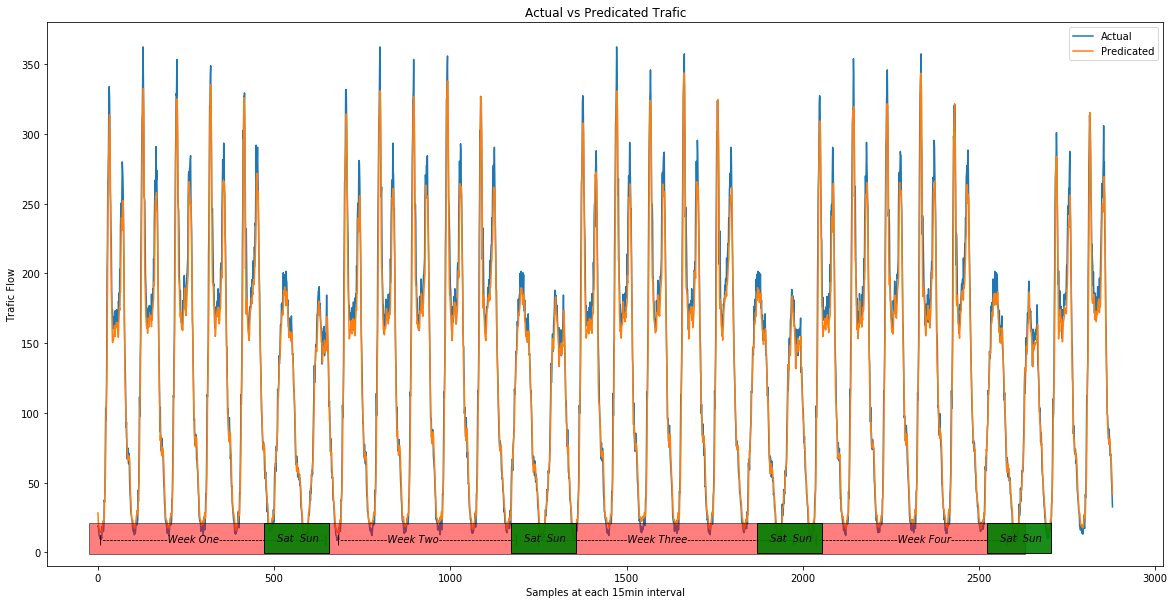

In [9]:
pyplot.figure(figsize=(20,10))
print(train_inv_y.shape,train_inv_yhat.shape)
train_inv_y =train_inv_y.reshape(2880)
train_inv_yhat =train_inv_yhat.reshape(2880)
pyplot.plot(train_inv_y[:96*30],label='Actual')
pyplot.plot(train_inv_yhat[:96*30],label='Predicated')
pyplot.xlabel("Samples at each 15min interval")
pyplot.ylabel("Trafic Flow")
pyplot.title('Actual vs Predicated Trafic')
pyplot.text(3, 8, '|------------------Week One-----------------------------|   |-------------Week Two---------------------|      |------------------------Week Three-----------------------------|      |----------------------Week Four---------------|  ', style='italic',
        bbox={'facecolor':'red', 'alpha':0.5, 'pad':10})
pyplot.text(500, 8, ' Sat  Sun', style='italic',
        bbox={'facecolor':'green', 'alpha':0.9, 'pad':10})
pyplot.text(1200, 8, ' Sat  Sun', style='italic',
        bbox={'facecolor':'green', 'alpha':0.9, 'pad':10})
pyplot.text(1900, 8, ' Sat  Sun', style='italic',
        bbox={'facecolor':'green', 'alpha':0.9, 'pad':10})
pyplot.text(2550, 8, ' Sat  Sun', style='italic',
        bbox={'facecolor':'green', 'alpha':0.9, 'pad':10})

pyplot.legend()
